In [241]:
#from get_opt import get_opt_quote
from pandas_datareader.data import Options
from dateutil.parser import parse
from datetime import datetime
from numpy import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
#from implied_vol import BlackScholes
from functools import partial
from scipy import optimize
import numpy as np
from scipy.interpolate import griddata

In [242]:
def CND(X):
 
    (a1,a2,a3,a4,a5) = (0.31938153, -0.356563782, 1.781477937, -1.821255978, 1.330274429)
    
    L = abs(X)
    K = 1.0 / (1.0 + 0.2316419 * L)
    w = 1.0 - 1.0 / sqrt(2*pi)*exp(-L*L/2.) * (a1*K + a2*K*K + a3*pow(K,3) +
 
    a4*pow(K,4) + a5*pow(K,5))
    
    if X<0:
        w = 1.0-w
 
    return w

In [243]:
def BlackScholes(v,CallPutFlag = 'c',S = 100.,X = 100.,T = 1.,r = 0.01):
 
    try:  
        d1 = (log(S/X)+(r+v*v/2.)*T)/(v*sqrt(T))
        d2 = d1-v*sqrt(T)
    
        if CallPutFlag=='c':
            return S*CND(d1)-X*exp(-r*T)*CND(d2)
 
        else:
            return X*exp(-r*T)*CND(-d2)-S*CND(-d1)

    except: return 0

In [244]:
def plot3D(X,Y,Z):
    fig = plt.figure()
    ax = Axes3D(fig, azim = -29, elev = 50)
 
    ax.plot(X,Y,Z,'o')
      
    plt.xlabel("expiry")
    plt.ylabel("strike")
    plt.show()

In [245]:
def calc_impl_vol(price = 5., right = 'c', underlying = 100., strike = 100., time = 1., rf = 0.01, inc = 0.001):
 
    f = lambda x: BlackScholes(x,CallPutFlag=right,S=underlying,X=strike,T=time,r=rf)-price
 
    return optimize.brentq(f,0.,5.)

In [246]:
def get_surf(ticker):
    #q = get_opt_quote(ticker.upper())
    
    q = Options(ticker, 'yahoo').get_all_data()
    q.reset_index(inplace=True)
    q.set_index('Symbol',inplace=True)
    vals = []
    
    print(q.head())

    for index, row in q.iterrows():
        if row['Type'] == 'put':
            underlying = float(row['Underlying_Price'])
            price = (float(row['Ask'])+float(row['Bid']))/2.0
            expd = (row['Expiry'] - datetime.now()).days
            exps = (row['Expiry'] - datetime.now()).seconds
            exp = (expd*24.*3600. + exps) / (365.*24.*3600.)
            #print(price,'p',underlying,float(row['Strike']),exp)
            try:
                impl = calc_impl_vol(price, 'p', underlying, float(row['Strike']), exp)
                vals.append([exp,float(row['Strike']),impl])
                #print(impl)
            except:
                pass
            
    vals = array(vals).T
    plot3D(vals[0],vals[1],vals[2])
    #mesh_plot2(vals[0],vals[1],vals[2])



In [247]:
def make_surf(X,Y,Z):
    XX,YY = meshgrid(linspace(min(X),max(X),350),linspace(min(Y),max(Y),350))
    ZZ = griddata(array([X,Y]).T,array(Z),(XX,YY))
    return XX,YY,ZZ

In [248]:
def mesh_plot2(X,Y,Z):
    fig = plt.figure()
    ax = Axes3D(fig, azim = -29, elev = 50)
    XX,YY,ZZ = make_surf(X,Y,Z)

    ax.plot_surface(XX,YY,ZZ)
    ax.contour(XX,YY,ZZ)
    plt.xlabel("expiry")
    plt.ylabel("strike")
    plt.show()
    

                     Strike     Expiry  Type    Last     Bid     Ask  Chg  \
Symbol                                                                      
AAPL180119C00002500     2.5 2018-01-19  call  168.04  166.15  167.40  0.0   
AAPL180119P00002500     2.5 2018-01-19   put    0.02    0.00    0.02  0.0   
AAPL180216C00002500     2.5 2018-02-16  call  170.91  170.20  170.85  0.0   
AAPL180420C00002500     2.5 2018-04-20  call  170.95  166.50  167.50 -1.0   
AAPL180420P00002500     2.5 2018-04-20   put    0.01    0.00    0.01  0.0   

                       PctChg  Vol  Open_Int        IV  Root IsNonstandard  \
Symbol                                                                       
AAPL180119C00002500  0.000000  6.0       3.0  0.000010  AAPL         False   
AAPL180119P00002500  0.000000  2.0       2.0  7.000001  AAPL         False   
AAPL180216C00002500  0.000000  1.0       1.0  6.507814  AAPL         False   
AAPL180420C00002500 -0.581564  5.0       5.0  0.000010  AAPL         F

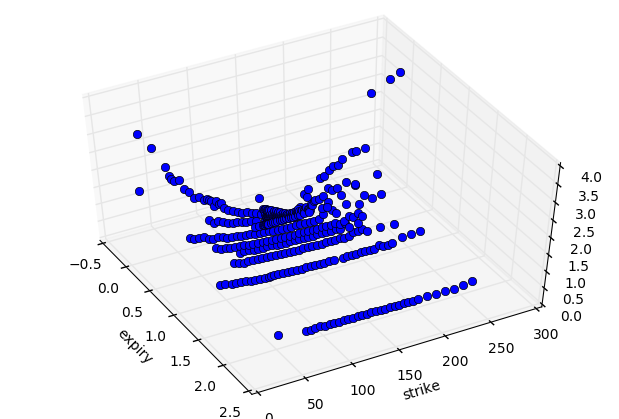

In [249]:
get_surf('AAPL')